In [1]:
# imports
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

Load Cifar-10

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape

170498071/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

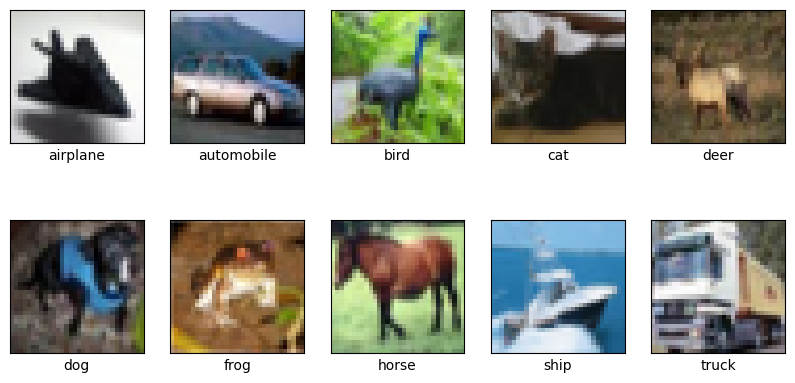

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Find the index of the first occurrence of each class in the training set
class_indices = [np.where(y_train == i)[0][0] for i in range(10)]

# Display one sample image for each class
plt.figure(figsize=(10, 5))
for i, index in enumerate(class_indices):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[index], cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

In [4]:
# Add Gaussian noise to the images
def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    # Clip the values to be between 0 and 1
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

# Add noise to the training and test sets
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

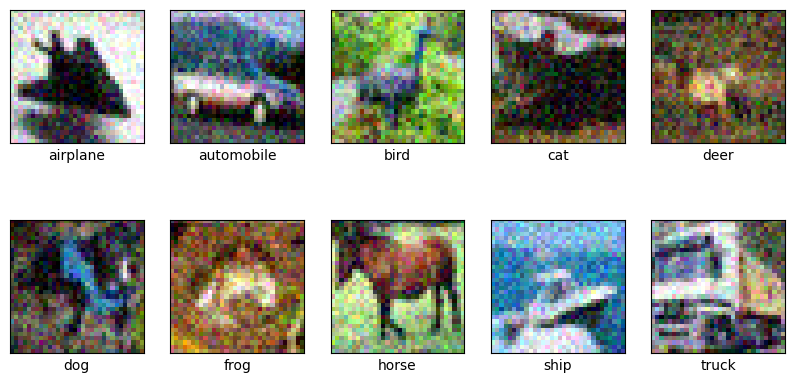

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Find the index of the first occurrence of each class in the training set
class_indices = [np.where(y_train == i)[0][0] for i in range(10)]

# Display one sample image for each class
plt.figure(figsize=(10, 5))
for i, index in enumerate(class_indices):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_noisy[index], cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

U-NET

In [6]:
def unet_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up5 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(3, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create an instance of the U-Net model
model = unet_model((16,16))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [7]:
model.fit(x_train_noisy[:10000], x_train[:10000], batch_size = 32, epochs = 5)

Epoch 1/5
313/313 [==============================] - 17s 16ms/step - loss: 0.0075 - accuracy: 0.6926
Epoch 2/5
313/313 [==============================] - 4s 13ms/step - loss: 0.0022 - accuracy: 0.7638
Epoch 3/5
313/313 [==============================] - 4s 13ms/step - loss: 0.0020 - accuracy: 0.7656
Epoch 4/5
313/313 [==============================] - 4s 12ms/step - loss: 0.0019 - accuracy: 0.7681
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 0.0019 - accuracy: 0.7704


Test

In [8]:
# Use the trained denoising model to predict denoised images
denoised_images = model.predict(x_test_noisy)

313/313 [==============================] - 1s 4ms/step


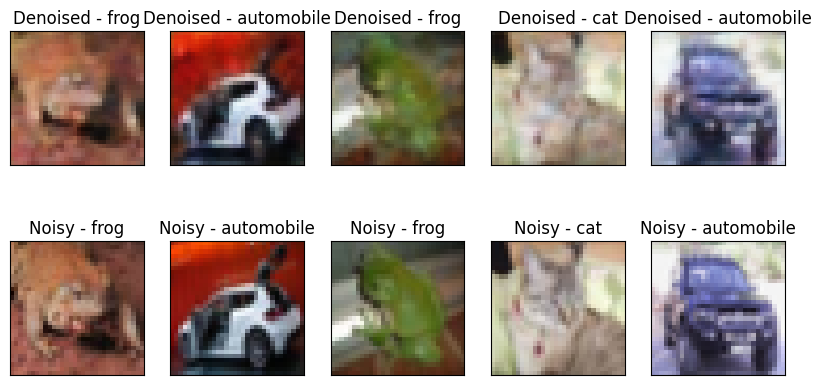

In [13]:
# Display a few sample noisy and denoised images with class labels as titles
plt.figure(figsize=(10, 5))
for i in range(5,10):
    # Display the noisy image with class label as title
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.title(f"Noisy - {class_names[y_test[i][0]]}")

    # Display the denoised image with class label as title
    plt.subplot(2, 5, (i + 6)%10)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(denoised_images[i])
    plt.title(f"Denoised - {class_names[y_test[i][0]]}")

plt.show()

Autoendoer + Unet